In [ ]:
!pip install numpy matplotlib tensorflow gym


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import gym


Se desea implementar un modelo del mundo, para poder utilizar con los distintos casos:

In [ ]:
def create_world_model(input_shape, output_shape, hidden_units=[64, 64]):
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=input_shape))
    for units in hidden_units:
        model.add(layers.Dense(units, activation='relu'))
    model.add(layers.Dense(np.prod(output_shape)))
    model.compile(optimizer='adam', loss='mse')
    return model

Una vez ya creada la funcion correspondiente al modelo del mundo, se desea hacer el entrenamiento para el mismo:

In [ ]:
def train_world_model(world_model, data, epochs=10):
    states, next_states, actions = data
    world_model.fit(states, next_states, epochs=epochs, verbose=1)

Ahora es muy importante poder ir incoporando y recolectar los datos iniciales para poder aprender de estos datos e interactuar con el entorno:


In [ ]:
def data(env, num_steps=1000):
    states = []
    next_states = []
    actions = []
    rewards = []
    state = env.reset()
    done = False

    for _ in range(num_steps):
        action = env.action_space.sample()
        next_state, reward, done, _ = env.step(action)

        states.append(state)
        next_states.append(next_state)
        actions.append(action)
        rewards.append(reward)

        state = next_state
        if done:
            state = env.reset()

    return np.array(states), np.array(next_states), np.array(actions), np.array(rewards)


Una vez ya creado el modelo del mundo con su entrenamiento y la recolección de datos, la idea es definir una política para que tome los distintos estados y pueda producir una acción.

In [ ]:
def create_policy_model(input_shape, output_shape, hidden_units=[64, 64]):
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=input_shape))
    for units in hidden_units:
        model.add(layers.Dense(units, activation='relu'))
    model.add(layers.Dense(output_shape, activation='linear'))
    model.compile(optimizer='adam', loss='mse')
    return model


Por último tambien hacer el entrenamiento para la política:

In [ ]:
def train_policy(policy_model, world_model, env, episodes=1000):
    for episode in range(episodes):
        state = env.reset()
        done = False
        while not done:
            action = policy_model.predict(state.reshape(1, -1))
            next_state, reward, done, _ = env.step(action)
            state = next_state

Ahora voy a llevar a cabo los distintos casos con sus pruebas para poder analizar y trabajar con ellos:

**Caso Cart-Pole**

In [ ]:
env = gym.make('CartPole-v1')
states, next_states, actions, rewards = data(env)
env.close()

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [ ]:
input_shape = states.shape[1:]  # tupla de enteros
output_shape = next_states.shape[1:]  # tupla de enteros

world_model = create_world_model(input_shape=input_shape, output_shape=output_shape)


In [ ]:
train_world_model(world_model, (states, next_states, actions), epochs=10)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1556
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0381
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0342
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0329
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0319
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0316
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0306
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0313
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0310
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0309


Tal como se puede observar en los resultados, que el entrenamiento se está trabajando con 10 épocas con 32 lotes de datos en cada época. En este caso lo que buscamos comparar es el resultado de "loss" ya que es la pérdida, se encarga de medir qué tan bien el modelo está prediciendo el siguiente estado. Un valor más bajo indica una mejor precisión.

Como se puede observar a lo largo de las distintas épocas, la pérdida disminuye con cada época. Indicando que el modelo está mejorando su capacidad para predecir el siguiente estado.
La pérdida en la última época es 0.0310. Esto indica que, después de 10 épocas, el modelo logró una pérdida relativamente baja, lo que es una buena señal de que el modelo aprendió a predecir el siguiente estado con cierta precisión.

**Análisis de Cart-Pole con lo esperado estudiado:**

En un problema como el Cart-Pole, el objetivo es que el modelo del mundo aprenda a predecir cómo cambia el estado del entorno en función de las acciones tomadas. Lo que se espera es que haya reduccuón en la pérdida a lo largo de las épocas.

Estos resultados son consistentes con los enfoques de modelos del mundo mencionados en la monografía. En particular, los modelos del mundo para el cart-pole suelen mostrar una disminución de la pérdida durante el entrenamiento, y este comportamiento es el esperado y por lo tanto coincide con el recibido anteriormente.

Se decide realicar un gráfico para poder analizar mejor la predicción del modelo del mundo con los estados reales:

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Error medio absoluto en la predicción de los estados: 0.12475428730249405


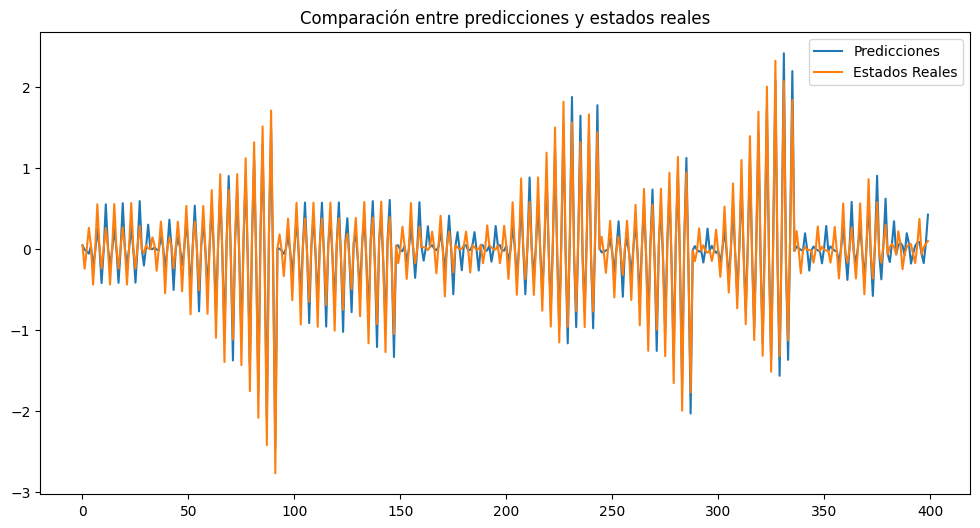

In [ ]:
predicted_next_states = world_model.predict(states)

error = np.mean(np.abs(predicted_next_states - next_states))
print(f'Error medio absoluto en la predicción de los estados: {error}')

plt.figure(figsize=(12, 6))
plt.plot(predicted_next_states[:100].flatten(), label='Predicciones')
plt.plot(next_states[:100].flatten(), label='Estados Reales')
plt.legend()
plt.title('Comparación entre predicciones y estados reales')
plt.show()


En el mismo se pueden observar varios puntos clave:

*   El error medio absoluto de 0.12 en este caso. Es decir, las predicciones del modelo del mundo difieren de los estados reales en 0.12 unidades.
*   En el gráfico, las líneas de color azul representan las predicciones del modelo, mientras que las naranjas representan los estados reales.
* En algunos puntos, las predicciones del modelo coinciden con los estados reales. Si bien en el resto no coinciden tanto se sigue manteniendo la estructura y el comportamiento general del entorno.
* Estos resultados sugieren que el modelo del mundo capta la dinámica general del entorno, pero tiene dificultades para predecir con precisión en situaciones de mayor variabilidad.
* Concluimos en que tal como lo estudiado, los modelos del mundo  tienden a tener un rendimiento razonable, pero no perfecto.


**Caso Grid World**

In [36]:
from sklearn.preprocessing import OneHotEncoder

env = gym.make('FrozenLake-v1', is_slippery=False)

states, next_states, actions, rewards = data(env)
all_possible_states = np.arange(env.observation_space.n).reshape(-1, 1) # Defino las categorías posibles

encoder = OneHotEncoder(sparse_output=False, categories='auto')
encoder.fit(all_possible_states)
states_encoded = encoder.transform(states.reshape(-1, 1))
next_states_encoded = encoder.transform(next_states.reshape(-1, 1))

input_shape = states_encoded.shape[1:]
output_shape = next_states_encoded.shape[1:]

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [37]:
world_model = create_world_model(input_shape=input_shape, output_shape=output_shape)
train_world_model(world_model, (states_encoded, next_states_encoded, actions), epochs=10)


Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0552
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0462
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0451
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0444 
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0432
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0430
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0438
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0429
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0427
Epoch 10/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0424


Observando los resultados, nuevamente lo que nos interesa es el valor de loss para saber que tan bien o mal funciona el modelo.
La función de pérdida es MSE.
Observando los valores, la pérdida disminuye desde la primera época a la última, demostrando que el modelo está aprendiendo y mejorando.

In [40]:
predictions = world_model.predict(states_encoded)
error = np.mean(np.abs(predictions - next_states_encoded))
print(f"Error medio absoluto en la predicción de los estados: {error}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Error medio absoluto en la predicción de los estados: 0.09003816627245396


Vamos a representar gráficamente los resultados

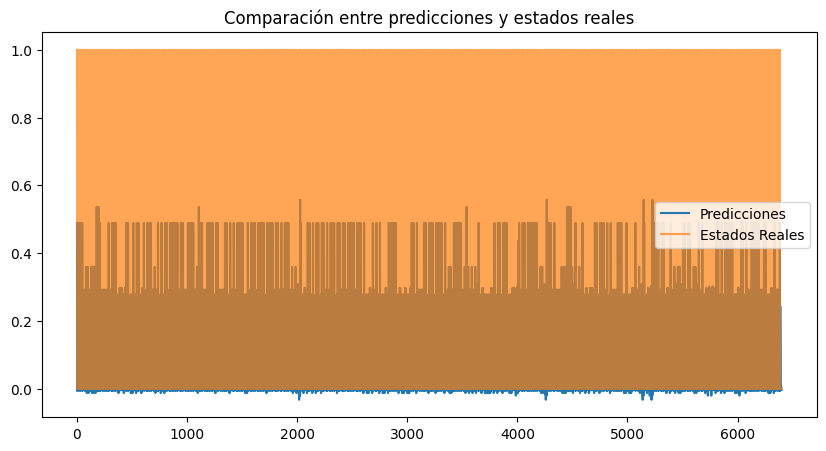

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(predictions[:400].flatten(), label="Predicciones")
plt.plot(next_states_encoded[:400].flatten(), label="Estados Reales", alpha=0.7)
plt.legend()
plt.title("Comparación entre predicciones y estados reales")
plt.show()

env.close()

Pruebo aumentando las épocas para ver si llego a tener un mejor resultado

In [41]:
world_model = create_world_model(input_shape, output_shape)
train_world_model(world_model, (states_encoded, next_states_encoded, actions), epochs=50)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0634
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0471 
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0440 
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0439
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0439 
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0432 
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0433 
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0430
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0437
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0433 
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0436 
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0434
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0429 
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0427
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0436
Epoch 16/50

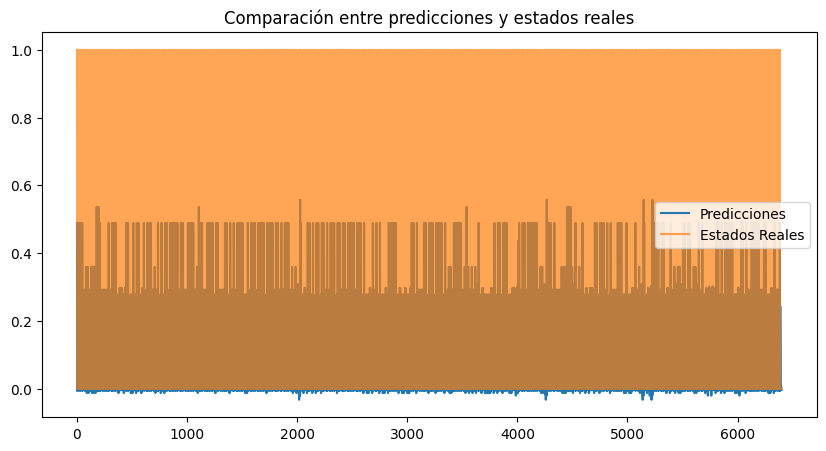

In [42]:
plt.figure(figsize=(10, 5))
plt.plot(predictions[:400].flatten(), label="Predicciones")
plt.plot(next_states_encoded[:400].flatten(), label="Estados Reales", alpha=0.7)
plt.legend()
plt.title("Comparación entre predicciones y estados reales")
plt.show()

env.close()

In [ ]:
predictions = world_model.predict(states_encoded)
error = np.mean(np.abs(predictions - next_states_encoded))
print(f"Error medio absoluto en la predicción de los estados: {error}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Error medio absoluto en la predicción de los estados: 0.08884990480841952


Por lo tanto, para este modelo, lo más eficiente es reducir el número de épocas a alrededor de 15, ya que después de este punto, no se observa una mejora significativa, lo que permite ahorrar tiempo y recursos sin afectar el rendimiento del modelo.

**Caso Cart Racing**

In [71]:
!pip install swig
!pip install gym[box2d]

  Using cached swig-4.2.1-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl.metadata (3.6 kB)
Using cached swig-4.2.1-py2.py3-none-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.9 MB)
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Using cached pygame-2.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.5 kB)
Using cached pygame-2.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376096 sha256=d298213627d55bc7d089f08fa43b9b549f9eb990010d53c6620e825f861ff307
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
  Attempting uninstall: pygame
    Found existing installation: pygame 2.6.0
    Uninstalling pygame-2.6.0:
      Successfully uninstalled pygame-2.6.0


Debido a las dimensiones que se utilizan para car racing realizo algunas modificaciones en las definiciones creadas anteriormente

In [80]:
def collect_data(env, num_steps=1000):
    states = []
    next_states = []
    actions = []
    state = env.reset()
    done = False

    for _ in range(num_steps):
        action = env.action_space.sample()
        next_state, reward, done, _ = env.step(action)

        state_resized = np.resize(state, (96, 96, 3)).flatten() / 255.0  #Normalizo
        next_state_resized = np.resize(next_state, (96, 96, 3)).flatten() / 255.0  # Normalizo

        states.append(state_resized)
        next_states.append(next_state_resized)
        actions.append(action)

        state = next_state
        if done:
            state = env.reset()

    return np.array(states), np.array(next_states), np.array(actions)

In [85]:
world_model = Sequential([
    InputLayer(input_shape=states.shape[1:]),
    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(np.prod(next_states.shape[1:]), activation='linear'),
    Reshape(next_states.shape[1:])
])

In [82]:
states, next_states, actions = collect_data(gym.make('CarRacing-v2'))
world_model.compile(optimizer='adam', loss='mse')
world_model.fit(states, next_states, epochs=20, batch_size=64, validation_split=0.2)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - loss: 0.2843 - val_loss: 9.6149
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.2482 - val_loss: 11.7284
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.2109 - val_loss: 7.4043
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.1538 - val_loss: 3.7660
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0904 - val_loss: 3.0188
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0510 - val_loss: 5.6270
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0441 - val_loss: 12.8822
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - loss: 0.0330 - val_loss: 1.4986
Epoch 9/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.0258 - val_loss: 4.0566
Epoch 10/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - loss: 0.0247 - val_loss: 1.2985
Epoch 11/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 0.0253 - val_loss: 0.4425
Epoch 12/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - loss: 0.0173 - val_

Como se puede observar, haremos foco nuevamente en los valores de loss, al disminuir la pérdida, se indica que el modelo está aprendiendo a predecir los estados con mayor precisión durante el entrenamiento. Para algunos casos hay ciertos picos, es decir que el modelo tiene algunas dificultades en algunos casos que se deben a la complejidad del entorno y a la variabilidad en los datos.

In [83]:
predicted_next_states = world_model.predict(states)
error = np.mean(np.abs(predicted_next_states - next_states))
print(f'Error medio absoluto en la predicción de los estados: {error}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step
Error medio absoluto en la predicción de los estados: 0.1577569707305163


El MAE da aproximadamente 0.158, lo que quiere decir que la diferencia entre las predicciones del modelo y los estados reales es de 0.158 unidades aproximadamente.

Para interpretar mejor, vamos a representar graficamente los resultados

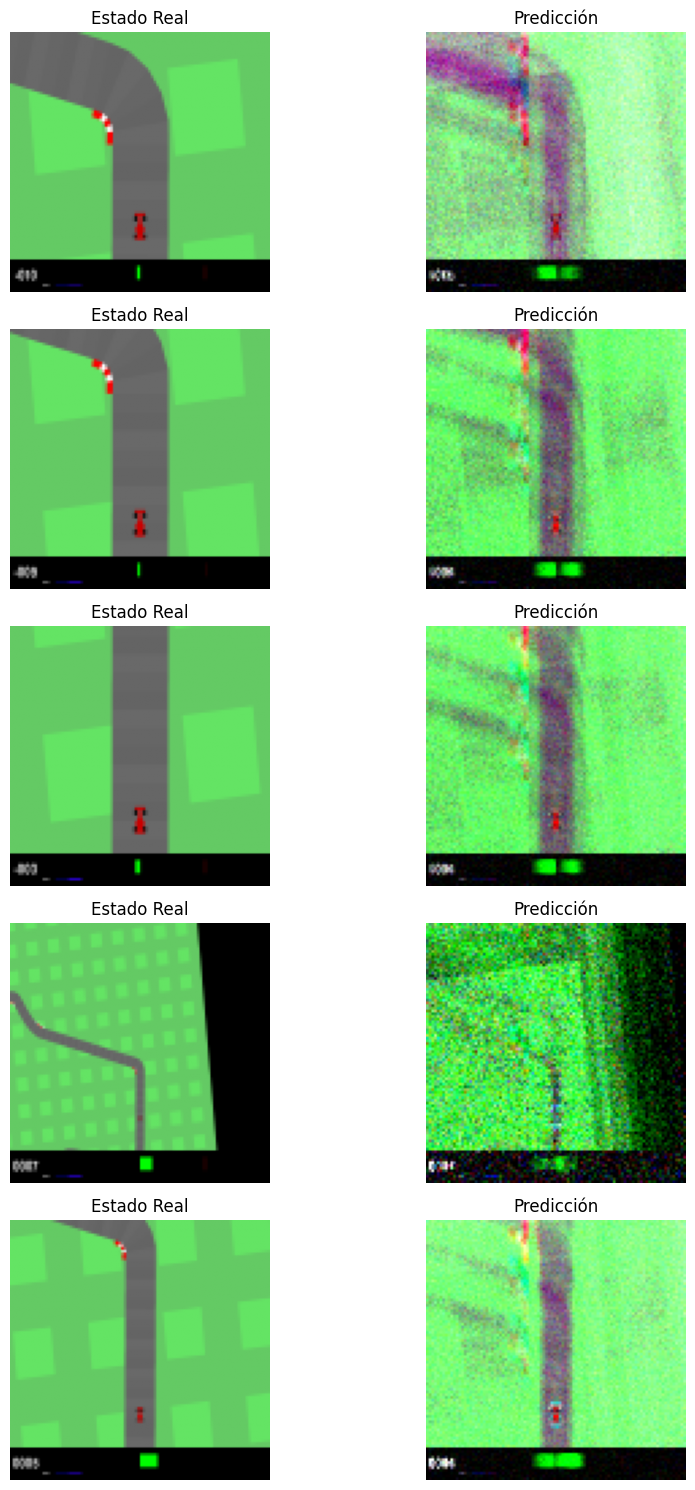

In [84]:
import numpy as np
import matplotlib.pyplot as plt

num_images_to_show = 5
sample_indices = np.random.choice(len(states), num_images_to_show, replace=False)

fig, axes = plt.subplots(num_images_to_show, 2, figsize=(10, 15))

for i, idx in enumerate(sample_indices):
    ax1, ax2 = axes[i]

    #  Imagen real
    ax1.imshow(states[idx].reshape(96, 96, 3))
    ax1.set_title('Estado Real')
    ax1.axis('off')

    # Imagen predicha
    ax2.imshow(predicted_next_states[idx].reshape(96, 96, 3))
    ax2.set_title('Predicción')
    ax2.axis('off')

plt.tight_layout()
plt.show()


En estas imágenes si bien a simple vista muestran un contorno bastante similar entre el Estado real y la predicción, observandolas más en profundidad se encuentra por ejemplo que empiezan a fallar en situaciones más complejas como cuando se realizan curvas,donde se empieza a perder o distorsionarse la imagen. Incluso en casos donde es recto se empieza a simular como si realmente hubiera una curva o si iniciara a realizarla.
Se puede observar como los resultados si bien fueron mejorando a lo largo del entrenamiento, se puede continuar ajustando el modelo para llegar a una mejor precisión.